In [1]:
import torch
import numpy as np
from fairseq.logging import progress_bar
from fairseq import options, tasks, utils
from argparse import Namespace
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from fairseq.models.speech_to_text.s2t_transformer_with_cif_contrast import S2TTransformerWithCifContrast as model
from fairseq.models.speech_to_text.s2t_transformer_with_cif_contrast import S2TTransformerWithCifContrastConfig

/home2/cwzhang98/anaconda3/envs/st/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
parser = options.get_generation_parser()
cfg = options.parse_args_and_arch(parser, input_args=[
    '/home2/cwzhang98/dataset/mustc',
    '--gen-subset', 'tst-COMMON_st',
    '--task', 'speech_to_text_cif_muti_contrast',
    '--max-tokens', '4000000',
    '--max-source-positions', '4000000',
    '--config-yaml', '/home2/cwzhang98/dataset/mustc/en-de/config_st.yaml',
    '--use-joint-dict'
])
if isinstance(cfg, Namespace):
    cfg = convert_namespace_to_omegaconf(cfg)
print(cfg)
task = tasks.setup_task(cfg.task)
tgt_dict = task.target_dictionary

2024-02-26 12:53:21 | INFO | fairseq.tasks.speech_to_text_cif_muti_contrast | joint dict size: 10000


{'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': None, 'path': None, 'post_process': None, 'quiet':

In [28]:
task.load_dataset(cfg.dataset.gen_subset)
ckpt_path = '/home2/cwzhang98/project/MYST/checkpoint/_checkpoint46.pt'
ckpt = torch.load(ckpt_path)

2024-02-26 12:53:21 | INFO | fairseq.tasks.speech_to_text_cif_muti_contrast | pre-tokenizer: {'tokenizer': None}
2024-02-26 12:53:21 | INFO | fairseq.tasks.speech_to_text_cif_muti_contrast | tokenizer: {'bpe': 'sentencepiece', 'sentencepiece_model': '/home2/cwzhang98/dataset/mustc/en-de/spm_unigram_10000_st.model'}
2024-02-26 12:53:22 | INFO | fairseq.data.audio.speech_to_text_dataset | 'tst-COMMON_st' has 0.00% OOV
2024-02-26 12:53:22 | INFO | fairseq.data.audio.speech_to_text_dataset | SpeechTextTripleDataset(split="tst-COMMON_st", n_samples=2_587, prepend_tgt_lang_tag=True, n_frames_per_step=1, shuffle=False, feature_transforms=None, waveform_transforms=None, dataset_transforms=CompositeAudioDatasetTransform(
))


In [29]:
model_args = S2TTransformerWithCifContrastConfig(**ckpt['cfg']['model'])
st_model = model.build_model(model_args, task)
st_model.load_state_dict(ckpt["model"], strict=True)

<All keys matched successfully>

In [30]:
# Load dataset
itr = task.get_batch_iterator(
    dataset=task.dataset(cfg.dataset.gen_subset),
    max_tokens=cfg.dataset.max_tokens,
    max_sentences=cfg.dataset.batch_size,
    ignore_invalid_inputs=cfg.dataset.skip_invalid_size_inputs_valid_test,
    required_batch_size_multiple=cfg.dataset.required_batch_size_multiple,
    seed=cfg.common.seed,
    num_shards=cfg.distributed_training.distributed_world_size,
    shard_id=cfg.distributed_training.distributed_rank,
    num_workers=cfg.dataset.num_workers,
    data_buffer_size=cfg.dataset.data_buffer_size,
).next_epoch_itr(shuffle=False)
progress = progress_bar.progress_bar(
    itr,
    log_format=cfg.common.log_format,
    log_interval=cfg.common.log_interval,
    default_log_format=("tqdm" if not cfg.common.no_progress_bar else "simple"),
)
if cfg.common.fp16:
    st_model.half()
if torch.cuda.is_available():
    st_model.cuda()
st_model.eval()

2024-02-26 12:53:26 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2024-02-26 12:53:26 | INFO | fairseq.tasks.fairseq_task | reuse_dataloader = True
2024-02-26 12:53:26 | INFO | fairseq.tasks.fairseq_task | rebuild_batches = True
2024-02-26 12:53:26 | INFO | fairseq.tasks.fairseq_task | batches will be rebuilt for each epoch
2024-02-26 12:53:26 | INFO | fairseq.tasks.fairseq_task | creating new batches for epoch 1


S2TTransformerWithCifContrast(
  (encoder): S2TTransformerWithCifContrastEncoder(
    (embed_tokens): Embedding(10000, 512, padding_idx=1)
    (dropout_module): FairseqDropout()
    (w2v_model): Wav2VecCtc(
      (w2v_encoder): Wav2VecEncoder(
        (w2v_model): Wav2Vec2Model(
          (feature_extractor): ConvFeatureExtractionModel(
            (conv_layers): ModuleList(
              (0): Sequential(
                (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
                (1): Dropout(p=0.0, inplace=False)
                (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
                (3): GELU(approximate='none')
              )
              (1): Sequential(
                (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
                (1): Dropout(p=0.0, inplace=False)
                (2): GELU(approximate='none')
              )
              (2): Sequential(
                (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias

In [31]:
sentence_sim_result = np.empty((0,))
for sample in progress:
    sample = utils.move_to_cuda(sample)
    with torch.no_grad():
        # speech repr
        speech_repr = st_model.encoder(
            sample['net_input']['src_tokens'],
            sample['net_input']['src_lengths'],
            sample['net_input']['transcript_lengths'],
            is_audio_input=True
        )['encoder_out'][0].transpose(0, 1)  # B T C
        # text repr
        text_repr = st_model.encoder(
            sample['source'],
            sample['source_lengths'],
            transcript_lengths=None,
            is_audio_input=False
        )['encoder_out'][0].transpose(0, 1)
        tok_sim = torch.nn.functional.cosine_similarity(speech_repr, text_repr, dim=-1)  # B T
        sentence_sim = tok_sim.mean(dim=-1).cpu().numpy()
        sentence_sim_result = np.append(sentence_sim_result, sentence_sim, axis=0)
        

In [32]:
print(sentence_sim_result)

[0.70973051 0.78528988 0.74959624 ... 0.63203013 0.45341763 0.54352778]


2024-02-26 13:01:12 | INFO | matplotlib.font_manager | generated new fontManager


<Axes: ylabel='Density'>

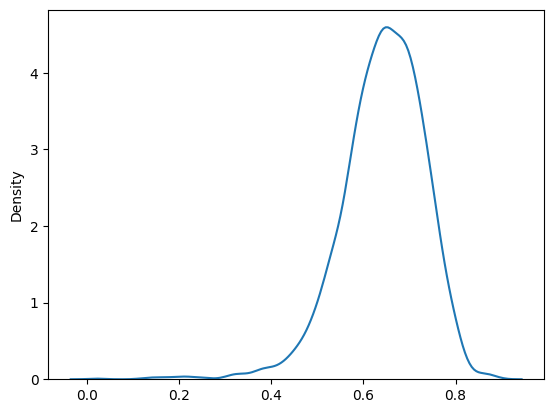

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(data=sentence_sim_result, label="tst", fill=False)

In [35]:
print('mean value:', np.mean(sentence_sim_result))

mean value: 0.6424015708602288
